In [1]:
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM

from common import read_from_hudi, write_to_hudi, create_spark_session
from config import get_selected_items_faostat

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [111]:
spark = create_spark_session("ForecastCropPrice")

In [ ]:
df_spark = spark.sql(f"""
    SELECT  ff.ProducerPrice_LCU_tonne_LCU_month,
            dd.YearMonth,
            ff.CropCode+
    FROM default.fact_faostat AS ff           
        JOIN default.dim_date  AS dd ON dd.DateINT = ff.DateINT
    WHERE ProducerPrice_LCU_tonne_LCU_month IS NOT NULL AND ProducerPrice_SLC_tonne_SLC_month IS NULL
    ORDER BY dd.YearMonth
""")


In [267]:
df_pandas = df_spark.toPandas()

missing_values = df_pandas.isnull().sum()
print(missing_values)

ProducerPrice_LCU_tonne_LCU_month    0
YearMonth                            0
CropCode                             0
dtype: int64


In [291]:
#crop_code = 27
crop_code = 687
#crop_name = df_crops[df_crops['CropCode'] == crop_code].first()['Crops']

df_true_crop = df_pandas[df_pandas['CropCode'] == crop_code] 

print(len(df_true_crop))

df_true_crop['date'] = pd.to_datetime(df_true_crop['YearMonth'], format='%Y%m')

df_time_series = df_true_crop[['ProducerPrice_LCU_tonne_LCU_month', 'YearMonth']]

# Chu·∫©n h√≥a gi√° tr·ªã ƒë·ªÉ tƒÉng ƒë·ªô ·ªïn ƒë·ªãnh
scaler = MinMaxScaler(feature_range=(0,1))
df_time_series['scaled_price'] = scaler.fit_transform(df_time_series[['ProducerPrice_LCU_tonne_LCU_month']])

# Chuy·ªÉn d·ªØ li·ªáu th√†nh d·∫°ng ph√π h·ª£p v·ªõi RNN/LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# X√¢y d·ª±ng t·∫≠p d·ªØ li·ªáu hu·∫•n luy·ªán
seq_length = 12  # D√πng 10 ng√†y tr∆∞·ªõc ƒë·ªÉ d·ª± ƒëo√°n ng√†y ti·∫øp theo
X, y = create_sequences(df_time_series['scaled_price'].values, seq_length)

# Chia t·∫≠p d·ªØ li·ªáu th√†nh train v√† test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# ƒê·ªãnh d·∫°ng l·∫°i d·ªØ li·ªáu cho RNN/LSTM (batch_size, time_steps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

148


C:\Users\Acer\AppData\Local\Temp\ipykernel_1332\3813947503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_crop['date'] = pd.to_datetime(df_true_crop['YearMonth'], format='%Y%m')
C:\Users\Acer\AppData\Local\Temp\ipykernel_1332\3813947503.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series['scaled_price'] = scaler.fit_transform(df_time_series[['ProducerPrice_LCU_tonne_LCU_month']])


In [292]:
rnn_model = Sequential([
    SimpleRNN(units=60, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
    Dense(units=1)
])

rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
6/6 [==============================] - 8s 448ms/step - loss: 0.2266 - val_loss: 0.0536
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0862 - val_loss: 0.0026
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0415 - val_loss: 0.0024
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0244 - val_loss: 0.0022
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0199 - val_loss: 0.0027
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0019
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0021
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 11/50
6/6 [===========

In [ ]:
#lstm_model = Sequential([
#    LSTM(units=50, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
#    Dense(units=1)
#])
#lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=64, return_sequences=True))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mse')


lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose = 2)

Epoch 1/100
95/95 - 9s - loss: 0.0563 - 9s/epoch - 99ms/step
Epoch 2/100
95/95 - 1s - loss: 0.0376 - 873ms/epoch - 9ms/step
Epoch 3/100
95/95 - 1s - loss: 0.0220 - 876ms/epoch - 9ms/step
Epoch 4/100
95/95 - 1s - loss: 0.0166 - 998ms/epoch - 11ms/step
Epoch 5/100
95/95 - 1s - loss: 0.0154 - 933ms/epoch - 10ms/step
Epoch 6/100
95/95 - 1s - loss: 0.0082 - 896ms/epoch - 9ms/step
Epoch 7/100
95/95 - 1s - loss: 0.0065 - 912ms/epoch - 10ms/step
Epoch 8/100
95/95 - 1s - loss: 0.0065 - 914ms/epoch - 10ms/step
Epoch 9/100
95/95 - 1s - loss: 0.0051 - 1s/epoch - 14ms/step
Epoch 10/100
95/95 - 1s - loss: 0.0039 - 1s/epoch - 11ms/step
Epoch 11/100
95/95 - 1s - loss: 0.0039 - 1s/epoch - 12ms/step
Epoch 12/100
95/95 - 1s - loss: 0.0034 - 1s/epoch - 11ms/step
Epoch 13/100
95/95 - 1s - loss: 0.0048 - 890ms/epoch - 9ms/step
Epoch 14/100
95/95 - 1s - loss: 0.0031 - 868ms/epoch - 9ms/step
Epoch 15/100
95/95 - 1s - loss: 0.0033 - 923ms/epoch - 10ms/step
Epoch 16/100
95/95 - 1s - loss: 0.0032 - 903ms/epoch -

2/2 [==============================] - 0s 13ms/step


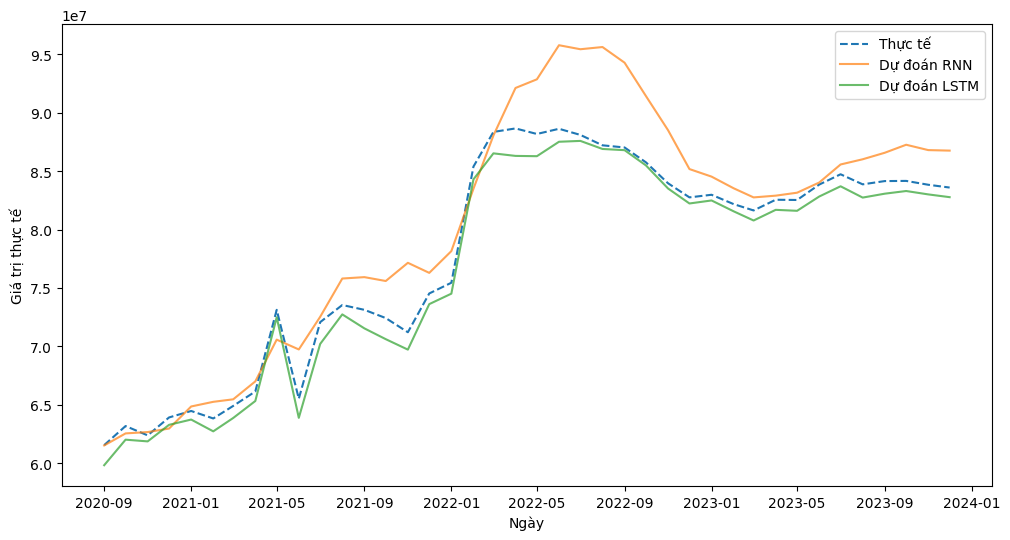

In [331]:
# D·ª± ƒëo√°n b·∫±ng RNN
rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)  # Chuy·ªÉn v·ªÅ ƒë∆°n v·ªã g·ªëc

# D·ª± ƒëo√°n b·∫±ng LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Chuy·ªÉn v·ªÅ ƒë∆°n v·ªã g·ªëc

# Chuy·ªÉn y_test v·ªÅ gi√° tr·ªã g·ªëc ƒë·ªÉ so s√°nh
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions = rnn_predictions[1:]
lstm_predictions =lstm_predictions[1:]
y_test_original = y_test_original[:-1]

# V·∫Ω k·∫øt qu·∫£ d·ª± ƒëo√°n
plt.figure(figsize=(12, 6))
#plt.plot(df_time_series['date'], df_time_series['ProducerPrice_LCU_tonne_LCU_month'], label="Th·ª±c t·∫ø", linestyle='dashed')
#plt.plot(df_time_series['date'].values[-len(y_test):], rnn_predictions, label="D·ª± ƒëo√°n RNN", alpha=0.7)
#plt.plot(df_time_series['date'].values[-len(y_test):], lstm_predictions, label="D·ª± ƒëo√°n LSTM", alpha=0.7)
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], y_test_original, label="Th·ª±c t·∫ø", linestyle='dashed')
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], rnn_predictions, label="D·ª± ƒëo√°n RNN", alpha=0.7)
plt.plot(df_true_crop['date'].values[-len(y_test)+1:], lstm_predictions, label="D·ª± ƒëo√°n LSTM", alpha=0.7)
plt.xlabel("Ng√†y")
plt.ylabel("Gi√° tr·ªã th·ª±c t·∫ø")
plt.legend()
plt.show()


In [332]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Chuy·ªÉn ƒë·ªïi gi√° tr·ªã d·ª± ƒëo√°n v·ªÅ ƒë∆°n v·ªã g·ªëc
#rnn_predictions = scaler.inverse_transform(rnn_model.predict(X_test))
#lstm_predictions = scaler.inverse_transform(lstm_model.predict(X_test))
#y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° cho RNN
rnn_mse = mean_squared_error(y_test_original, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(y_test_original, rnn_predictions)
rnn_r2 = r2_score(y_test_original, rnn_predictions)

# T√≠nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° cho LSTM
lstm_mse = mean_squared_error(y_test_original, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_original, lstm_predictions)
lstm_r2 = r2_score(y_test_original, lstm_predictions)

# In k·∫øt qu·∫£
print(f"üîπ Hi·ªáu su·∫•t m√¥ h√¨nh RNN:")
print(f"  - MSE: {rnn_mse:.4f}")
print(f"  - RMSE: {rnn_rmse:.4f}")
print(f"  - MAE: {rnn_mae:.4f}")
print(f"  - R¬≤ Score: {rnn_r2:.4f}")

print(f"\nüîπ Hi·ªáu su·∫•t m√¥ h√¨nh LSTM:")
print(f"  - MSE: {lstm_mse:.4f}")
print(f"  - RMSE: {lstm_rmse:.4f}")
print(f"  - MAE: {lstm_mae:.4f}")
print(f"  - R¬≤ Score: {lstm_r2:.4f}")


üîπ Hi·ªáu su·∫•t m√¥ h√¨nh RNN:
  - MSE: 11692187582464.0000
  - RMSE: 3419384.0000
  - MAE: 2597676.7500
  - R¬≤ Score: 0.8542

üîπ Hi·ªáu su·∫•t m√¥ h√¨nh LSTM:
  - MSE: 1270664134656.0000
  - RMSE: 1127237.3750
  - MAE: 1011732.5000
  - R¬≤ Score: 0.9842


In [301]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import defaultdict


def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)



def prepare_data_for_crop(df, crop_code, sequence_length=12, test_length=24):
    """
    Chu·∫©n b·ªã d·ªØ li·ªáu cho m·ªôt lo·∫°i c√¢y tr·ªìng c·ª• th·ªÉ
    """
    # L·ªçc d·ªØ li·ªáu theo crop_code
    crop_data = df[df['CropCode'] == crop_code].copy()
 
    if len(crop_data) < sequence_length + 1:
        return None, None, None, None, None, None, None

    train_data = crop_data[:-test_length]
    test_data = crop_data[-(test_length + sequence_length):]


    if len(train_data) < sequence_length + 1:
        return None, None, None, None, None, None, None
    
    # Chu·∫©n h√≥a d·ªØ li·ªáu
    scaler = MinMaxScaler()
    scaled_train_data = scaler.fit_transform(train_data[['ProducerPrice_LCU_tonne_LCU_month']])
    scaled_test_data = scaler.transform(test_data[['ProducerPrice_LCU_tonne_LCU_month']])
    X_train, y_train = create_sequences(scaled_train_data)
    X_test, y_test = create_sequences(scaled_test_data)
    
    return X_train, X_test, y_train, y_test, scaler, train_data, test_data

def create_rnn_model(sequence_length):
    """
    T·∫°o m√¥ h√¨nh RNN
    """
    model = Sequential([
        SimpleRNN(64, input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

def create_lstm_model(sequence_length):
    """
    T·∫°o m√¥ h√¨nh LSTM
    """
    model = Sequential([
        LSTM(64, input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model

def train_and_evaluate_models_for_crop(df, crop_code, sequence_length = 12, test_length = 24):
    """
    Hu·∫•n luy·ªán v√† ƒë√°nh gi√° m√¥ h√¨nh cho m·ªôt lo·∫°i c√¢y tr·ªìng
    """
    # Chu·∫©n b·ªã d·ªØ li·ªáu
    X_train, X_test, y_train, y_test, scaler, train_data, test_data = prepare_data_for_crop(df, crop_code, sequence_length,test_length)
    
    if X_train is None:
        print(f"Kh√¥ng ƒë·ªß d·ªØ li·ªáu cho lo·∫°i c√¢y tr·ªìng {crop_code}")
        return None, None, None, None, None
    
    # T·∫°o v√† hu·∫•n luy·ªán m√¥ h√¨nh RNN
    rnn_model = create_rnn_model(sequence_length)
    rnn_history = rnn_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1)
    
    # T·∫°o v√† hu·∫•n luy·ªán m√¥ h√¨nh LSTM
    lstm_model = create_lstm_model(sequence_length)
    lstm_history = lstm_model.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                validation_split=0.2,
                                verbose=1)
    # ƒê√°nh gi√° m√¥ h√¨nh
    rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
    lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)


    print(f"\nK·∫øt qu·∫£ cho lo·∫°i c√¢y tr·ªìng {crop_code}:")
    print(f"RNN Model - Test Loss: {rnn_loss:.4f}, Test MAE: {rnn_mae:.4f}")
    print(f"LSTM Model - Test Loss: {lstm_loss:.4f}, Test MAE: {lstm_mae:.4f}")
    
    # V·∫Ω ƒë·ªì th·ªã so s√°nh
    plt.figure(figsize=(12, 6))
    plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
    plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
    plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
    plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
    plt.title(f'Model Loss Comparison for Crop Code {crop_code}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return rnn_model, lstm_model, scaler, train_data, test_data

def predict_test_period(model, test_data, scaler, sequence_length=12):
    """
    D·ª± ƒëo√°n gi√° cho giai ƒëo·∫°n test
    """
    scaled_test_data = scaler.transform(test_data[['ProducerPrice_LCU_tonne_LCU_month']])
    predictions = []
    
    for i in range(len(scaled_test_data) - sequence_length):
        sequence = scaled_test_data[i:(i + sequence_length)]
        pred = model.predict(sequence.reshape(1, sequence_length, 1))
        predictions.append(pred[0])
    
    predictions = scaler.inverse_transform(np.array(predictions))
    actual_values = test_data['ProducerPrice_LCU_tonne_LCU_month'].values[sequence_length:]
    dates = test_data['YearMonth'].values[sequence_length:]
    
    return predictions, actual_values, dates

def plot_predictions_vs_actual(crop_code, dates, actual_values, rnn_predictions, lstm_predictions):
    """
    V·∫Ω bi·ªÉu ƒë·ªì so s√°nh d·ª± ƒëo√°n v·ªõi gi√° tr·ªã th·ª±c t·∫ø
    """
    plt.figure(figsize=(15, 7))
    
    # Chuy·ªÉn ƒë·ªïi dates th√†nh datetime n·∫øu ch∆∞a ph·∫£i
    if not pd.api.types.is_datetime64_any_dtype(dates):
        dates = pd.to_datetime(dates)
    
    # V·∫Ω d·ªØ li·ªáu th·ª±c t·∫ø
    plt.plot(dates, actual_values, label='Actual Values', color='blue', alpha=0.7)
    
    # V·∫Ω d·ª± ƒëo√°n RNN
    plt.plot(dates, rnn_predictions, label='RNN Predictions', color='red', linestyle='--')
    
    # V·∫Ω d·ª± ƒëo√°n LSTM
    plt.plot(dates, lstm_predictions, label='LSTM Predictions', color='green', linestyle='--')
    
    # ƒê·ªãnh d·∫°ng bi·ªÉu ƒë·ªì
    plt.title(f'Price Predictions vs Actual Values for Crop Code {crop_code}')
    plt.xlabel('Date')
    plt.ylabel('Price (LCU/tonne)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Xoay nh√£n tr·ª•c x ƒë·ªÉ d·ªÖ ƒë·ªçc
    plt.xticks(rotation=45)
    
    # ƒêi·ªÅu ch·ªânh layout ƒë·ªÉ tr√°nh c·∫Øt nh√£n
    plt.tight_layout()

    # Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì
    plt.show()

    rnn_r2 = r2_score(actual_values, rnn_predictions)
    lstm_r2 = r2_score(actual_values, lstm_predictions)

    print(f"RNN Model - Test R2: {rnn_r2:.4f}")
    print(f"LSTM Model - Test R2: {lstm_r2:.4f}")

def train_and_predict_all_crops(df, crop_codes=None, sequence_length=12, test_length=24):
    """
    Hu·∫•n luy·ªán v√† d·ª± ƒëo√°n cho c√°c lo·∫°i c√¢y tr·ªìng ƒë∆∞·ª£c ch·ªâ ƒë·ªãnh    
    """
    df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y%m')

    crop_models = defaultdict(dict)
    crop_predictions = defaultdict(dict)
    
    # N·∫øu kh√¥ng c√≥ danh s√°ch crop_codes, l·∫•y t·∫•t c·∫£ c√°c lo·∫°i c√¢y
    if crop_codes is None:
        crop_codes = df['CropCode'].unique()
    else:
        # Ki·ªÉm tra xem c√°c crop_code c√≥ t·ªìn t·∫°i trong d·ªØ li·ªáu kh√¥ng
        existing_codes = df['CropCode'].unique()
        invalid_codes = [code for code in crop_codes if code not in existing_codes]
        if invalid_codes:
            print(f"C·∫£nh b√°o: C√°c m√£ c√¢y tr·ªìng sau kh√¥ng t·ªìn t·∫°i trong d·ªØ li·ªáu: {invalid_codes}")
            crop_codes = [code for code in crop_codes if code in existing_codes]
            if not crop_codes:
                print("Kh√¥ng c√≥ m√£ c√¢y tr·ªìng h·ª£p l·ªá ƒë·ªÉ d·ª± ƒëo√°n.")
                return crop_models, crop_predictions
    
    print(f"\nB·∫Øt ƒë·∫ßu d·ª± ƒëo√°n cho {len(crop_codes)} lo·∫°i c√¢y tr·ªìng:")
    
    for crop_code in crop_codes:
        print(f"\nX·ª≠ l√Ω lo·∫°i c√¢y tr·ªìng: {crop_code}")
        
        # Hu·∫•n luy·ªán m√¥ h√¨nh
        rnn_model, lstm_model, scaler, train_data, test_data = train_and_evaluate_models_for_crop(df, crop_code, sequence_length, test_length)
        
        if rnn_model is not None:
            # L∆∞u m√¥ h√¨nh
            crop_models[crop_code] = {
                'rnn': rnn_model,
                'lstm': lstm_model,
                'scaler': scaler
            }

            # L·∫•y d·ªØ li·ªáu l·ªãch s·ª≠ cho lo·∫°i c√¢y n√†y
            historical_data = df[df['CropCode'] == crop_code].sort_values('YearMonth')
            
            # D·ª± ƒëo√°n cho giai ƒëo·∫°n test
            rnn_predictions, actual_values, dates = predict_test_period(rnn_model, test_data, scaler, sequence_length)
            lstm_predictions, _, _ = predict_test_period(lstm_model, test_data, scaler, sequence_length)
            
            crop_predictions[crop_code] = {
                'rnn': rnn_predictions,
                'lstm': lstm_predictions,
                'actual': actual_values,
                'dates': dates
            }
             # V·∫Ω bi·ªÉu ƒë·ªì so s√°nh
            plot_predictions_vs_actual(crop_code, dates, actual_values, rnn_predictions, lstm_predictions)
            
    
    return crop_models, crop_predictions




B·∫Øt ƒë·∫ßu d·ª± ƒëo√°n cho 1 lo·∫°i c√¢y tr·ªìng:

X·ª≠ l√Ω lo·∫°i c√¢y tr·ªìng: 687
Epoch 1/50
3/3 [==============================] - 6s 355ms/step - loss: 0.5942 - mae: 0.6621 - val_loss: 0.0107 - val_mae: 0.1023
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 0.2057 - mae: 0.3642 - val_loss: 0.0373 - val_mae: 0.1925
Epoch 3/50
3/3 [==============================] - 0s 36ms/step - loss: 0.1301 - mae: 0.2815 - val_loss: 0.0818 - val_mae: 0.2833
Epoch 4/50
3/3 [==============================] - 0s 33ms/step - loss: 0.0945 - mae: 0.2509 - val_loss: 0.0900 - val_mae: 0.2945
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0810 - mae: 0.2058 - val_loss: 0.0478 - val_mae: 0.2132
Epoch 6/50
3/3 [==============================] - 0s 31ms/step - loss: 0.0651 - mae: 0.2084 - val_loss: 0.0108 - val_mae: 0.1012
Epoch 7/50
3/3 [==============================] - 0s 36ms/step - loss: 0.0608 - mae: 0.1979 - val_loss: 0.0026 - val_mae: 0.0487
Epoch 8/

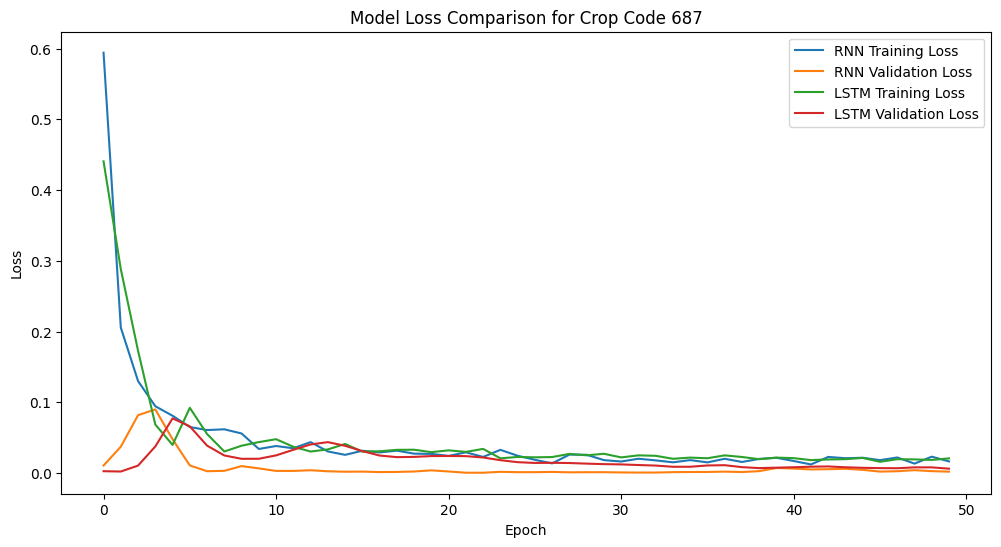

1/1 [==============================] - 0s 26ms/step


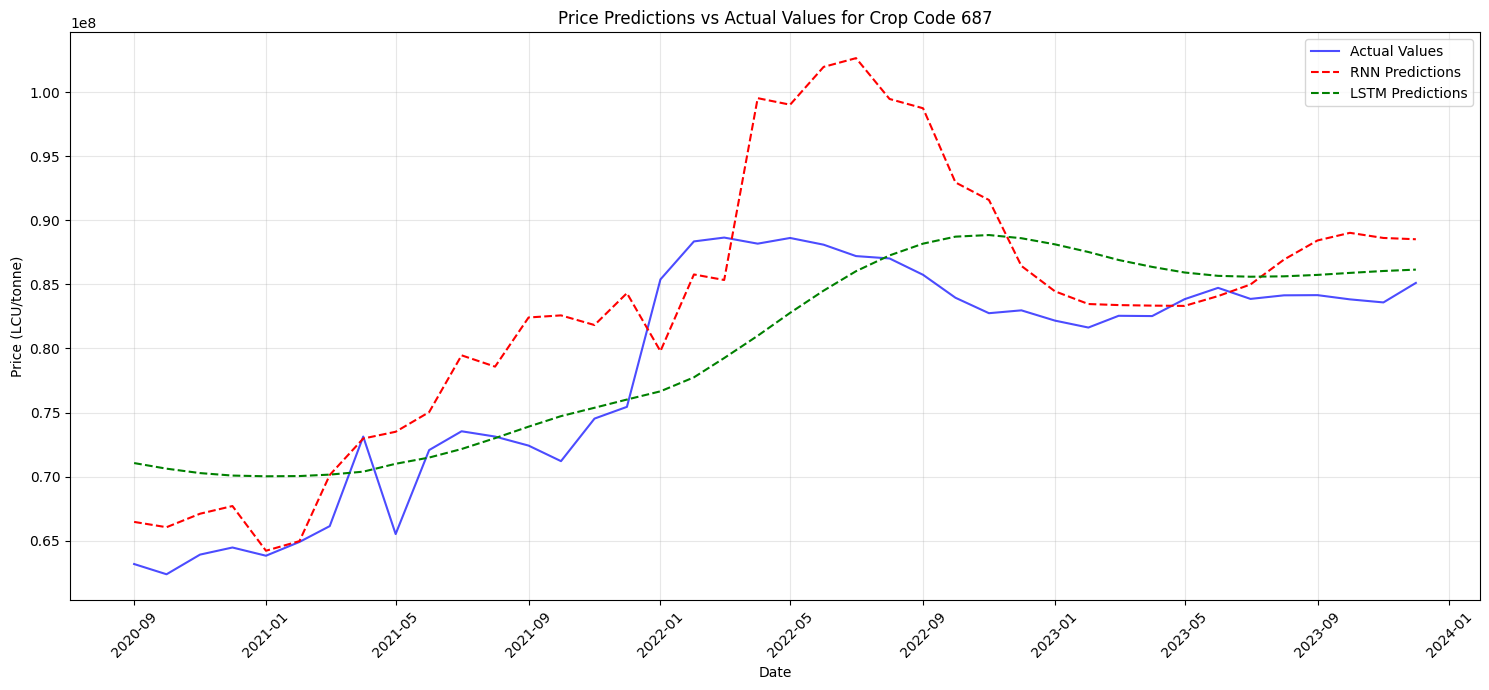

RNN Model - Test R2: 0.3721
LSTM Model - Test R2: 0.6845


In [303]:
df_pandas3 = df_pandas.copy()
# Hu·∫•n luy·ªán v√† d·ª± ƒëo√°n cho t·∫•t c·∫£ c√°c lo·∫°i c√¢y tr·ªìng
crop_models, crop_predictions = train_and_predict_all_crops(df_pandas3, [687], test_length = 40)



In [ ]:
# L∆∞u k·∫øt qu·∫£ d·ª± ƒëo√°n v√†o file
results = []
for crop_code, predictions in crop_predictions.items():
    for month in range(12):
        results.append({
            'CropCode': crop_code,
            'Month': month + 1,
            'RNN_Prediction': predictions['rnn'][month][0],
            'LSTM_Prediction': predictions['lstm'][month][0]
        })

results_df = pd.DataFrame(results)
results_df.to_csv('crop_price_predictions.csv', index=False)
print("\nK·∫øt qu·∫£ d·ª± ƒëo√°n ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o file 'crop_price_predictions.csv'")

In [333]:
spark.stop()